In [1]:
import flopy as fp
import numpy as np
import pandas as pd
import geopandas as gp
import matplotlib.pyplot as plt
import os
import sys

from flopy.utils.gridgen import Gridgen 
from flopy.utils.gridintersect import GridIntersect
from flopy.utils.triangle import Triangle as Triangle
import shapely
from shapely.geometry import Polygon, Point, LineString, MultiLineString, MultiPoint, MultiPolygon,shape

flopy is installed in C:\Users\schorppl\AppData\Local\Continuum\anaconda3\lib\site-packages\flopy


## Ce notebook a pour but de présenter les possibilités de flopy sur le raffinement des grilles régulières et leur incorporation dans un modèle

Flopy permet le raffinement des grilles rectangulaires grâce au programme gridgen. Il fonctionne comme ceci :

- Il faut d'abord créer une fausse simulation + modèle + discrétisation (normale) 
- Qui servent ensuite à créer un objet (au sens programation orientée objet) : "Gridgen"
- Cet objet on peut lui spécifier des zones à raffiner (grâce à des shp ou de simples polygones)
- Une fois qu'on lui dit tout ce qu'on attendait de lui on peut créer la nouvelle grille 
- On extrait les différentes propriétées de cette grille et on les assigne à un pacage DISV ou DISU (**Discrétisation par Vertice ou Discrétisation Non Structurée**)



#### Ici est donc présenté un simple modèle 2D avec plusieurs méthodes de raffinement

In [2]:
model_dir = "workspace"
gridgen_dir = "chenis_gridgen"
model_name = "Modele_raffine"
exe_name= "../../../../../exe/mf6"

Remarque : Gridgen génère **beaucoup** de fichiers qui se créent automatiquement dans le dossier du notebook, ils peuvent vite être volumineux.

In [3]:
# some fu

               
def get_heads(model_name,workspace):
        
    """
    Function that returns the heads from the headfile
    model_name : str, the name of the current model
    workspace : str, the path to workspace (where output files are stored)
    obj : bool, if we want to retrieve the head object rather than the computed heads for the last stress period
    """
    
    headfile = '{}.hds'.format(model_name)
    fname = os.path.join(workspace,headfile)    
    hdobj = fp.utils.HeadFile(fname, precision='double') 
    head  = hdobj.get_data()
    
    return head

def get_spdis(model_name,workspace):
    
    """
    Function that returns the specific discharge from the cbcfile
    """
    
    spdfile = '{}.cbc'.format(model_name)
    fname = os.path.join(workspace,spdfile)    
    spdobj = fp.utils.CellBudgetFile(fname, precision='double')  
    spd  = spdobj.get_data(text="SPDIS")
    
    return spd

def get_cbc(model_name,workspace):
    cbcfile = '{}.cbc'.format(model_name)
    fname = os.path.join(workspace,cbcfile)    
    cbcobj = fp.utils.CellBudgetFile(fname, precision='double')  
    return cbcobj

### Définissons déjà notre domaine

In [4]:
#spatial parameters

# coordinates xmin/xmax/ymin/ymax
x0,y0,x1,y1 = 660e3,615e4,710.3e3,620.5e4

Lx = x1-x0 # length x
Ly = y1-y0 # length y
nlay = 1 # number of layer(s)
delc = delr = 1000 # resolution (size of cells in y and x direction, resp.)
ncol = int(Lx/delr) 
nrow = int(Ly/delc)
top = 50 # top horizontal at 50 m
botm = -50 # botom horizontal at -50 m

### Pour pimenter le tout on peut délimiter notre modèle avec un shapefile (Ici l'aquifère du Roussillon)

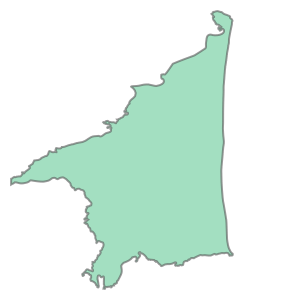

In [5]:
path_shp = "data/limiteModeleRoussillon_poly.shp" # chemin vers le shapefile
gp.read_file(path_shp).geometry[0]

### On va donc créer notre faux modèle afin de faire un faux dis package qui sera ensuite passé à gridgen

In [6]:
# create fake simulation
sim = fp.mf6.MFSimulation(sim_name='refine_mf6_fake', version='mf6', exe_name=exe_name, 
                             sim_ws=gridgen_dir)

# create fake gwf model
gwf = fp.mf6.ModflowGwf(sim, modelname=model_name,
                           model_nam_file='{}.nam'.format(model_name))

# create fake dis
dis = fp.mf6.ModflowGwfdis(gwf,nlay=nlay, nrow=nrow, ncol=ncol,
                              delr=delr, delc=delc,
                              top=top, botm=botm,xorigin=x0,yorigin=y0,idomain=1)

In [7]:
# create a gridgen object
g = Gridgen(dis, model_ws=gridgen_dir,exe_name="../../../../../exe/gridgen.exe")

On a maintenant un objet gridgen, on peut donc s'amuser à lui imposer des zones de raffinements et des limites

#### Limitons notre modèle au shapefile du Roussillon avec add_active_domain !

In [8]:
# define the domain using a shapefile
path_shp = "../data/limiteModeleRoussillon_poly"
g.add_active_domain(path_shp,[0]) # path to shp or coordinates, layers


Précision ici : On peut fournir à Gridgen un shapefile ou une liste (format [[[x1,y1],[x2.y2],[...,...]) de coordonnées. 

Quand c'est un shapefile **IL NE FAUT PAS ECRIRE ".SHP"** à la fin du path. De plus le paramètre "layer" doit être une liste ou array.

Et également le chemin (du shp) est relatif à celui de l'objet gridgen (ici par rapport au dossier "chenis_gridgen"

#### Maintenant cela fait on peut peut-être voir ce que cela a fait. Donc pour cela il faut lancer la "construction" de la grille avec la méthode .build() puis on peut ensuite plotter le maillage

Text(710000, 6180000, "Bah alors ? C'est pas mal ;)")

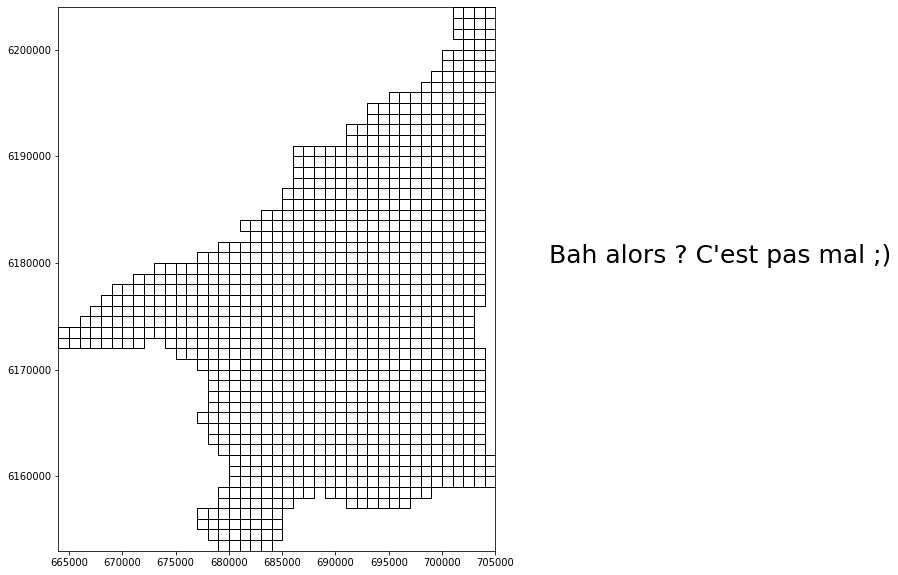

In [9]:
g.build()
fig,ax = plt.subplots(figsize=(10,10))
g.plot(ax=ax)
ax.set_aspect("equal")
plt.text(710000,6180000,"Bah alors ? C'est pas mal ;)",fontsize="25")

### Maintenant ajoutons quelques features que l'on va raffiner (puits, rivières, etc.)

#### Lorsque que l'on souhaite raffiner on utilise add_refinement_features. Il faut :
- lui spécifier le chemin du shp  (sans .shp)
- le type de géométrie (polygon, ligne ou point)
- le niveau de raffinement (intensité du raffinement si vous préférez)
- couches sur lesquelles l'appliquer

In [10]:
#riv
Riv_path = "../data/Tet"
g.add_refinement_features(Riv_path,"line",2,[0]) # shp, features type, level of refinement, layers

Si l'on souhaite voir l'effet de ce raffinement il est nécessaire de reconstruire la grille

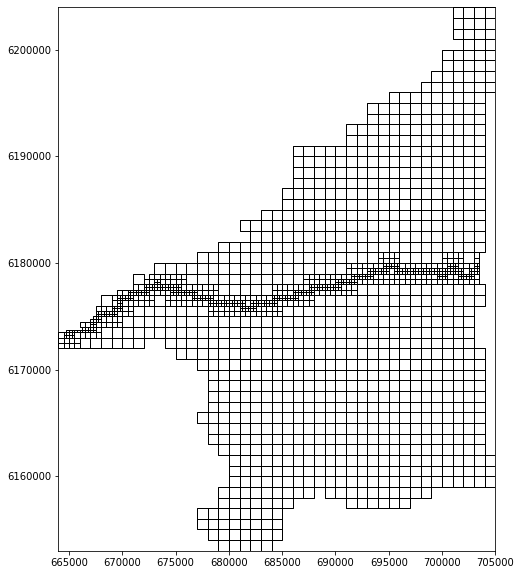

In [11]:
# plot
g.build() # build grid
fig,ax = plt.subplots(figsize=(10,10))
g.plot(ax=ax)
ax.set_aspect("equal") # dx and dy equal

### Ajouts de puits

Créons d'abord quelques fausses données de positions de puits (pour l'exemple)

In [12]:
# create some fake data
import random

coor_wel = []
n_wel = 34
x = np.round(x0+Lx*np.random.rand(n_wel))
y = np.round(y0+Ly*np.random.rand(n_wel))

for x,y in zip(x,y):
    coor_wel.append((x,y))
coor_wel[:5]

[(680320.0, 6197044.0),
 (698577.0, 6172684.0),
 (691971.0, 6168296.0),
 (668451.0, 6174293.0),
 (676790.0, 6153037.0)]

Notez que la liste coor_wel contient les coordonnées des puits dans une liste assez standard [(x1,y1),(x2,y2),...]. Cela n'est cependant pas si simple pour les lignes ou polygones qui doivent être compris dans une double liste : 
[[(x1,y1),(x2,y2),...]]. 

Cela pour fournir eventuellement plusieurs polygones d'un coup (probablement, j'ai pas testé)

In [13]:
#add refinement around wells
g.add_refinement_features(coor_wel,"point",3,[0])

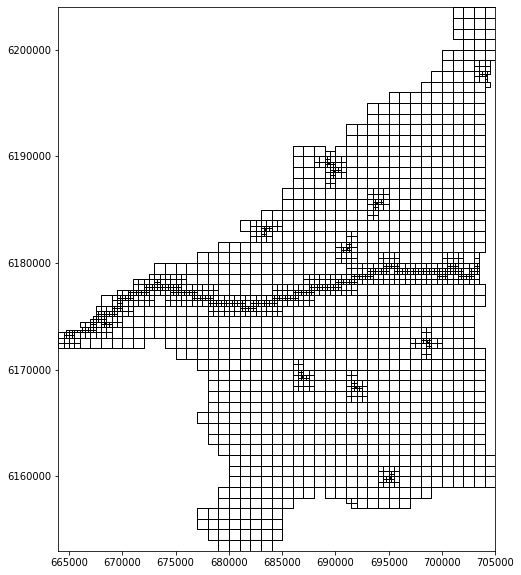

In [14]:
# plot
g.build() # build grid
fig,ax = plt.subplots(figsize=(10,10))
g.plot(ax=ax)
ax.set_aspect("equal") # dx and dy equal

## On peut maintenant transférer tout ça dans un un package de discrétisation. Nous en avons 2 à disposition :
- Le package DISV ou par vertices
- le package DISU ou complètement non structuré

On les récupère avec les méthodes get_gridprops_disv et get_gridprops_disu6

In [15]:
gprop = g.get_gridprops_disv()

In [16]:
gprop.keys()

dict_keys(['nlay', 'ncpl', 'top', 'botm', 'nvert', 'vertices', 'cell2d'])

Chaque package possède certains paramètres qui lui sont nécessaire. Pour disv il faut au minimum fournir au package les vecteurs suivants : 
- nvert : nombre de vertices (sommets)
- vertices : coordonnées des vertices [id vert, xv,yv]
- cell2d : liste des cellules du modèle (id cell, xc, yc, nombre de vertices connectées à la cell, liste de ces vertices)

In [17]:
# on extrait donc ces propriétés pour les passer plus tard au package disv
nlay = gprop["nlay"]
ncpl = gprop["ncpl"]
top = gprop["top"]
botm = gprop["botm"]
nvert = gprop["nvert"]
vert = gprop["vertices"]
cell2d = gprop["cell2d"]

In [18]:
vert[:3]

[[0, 701000.0, 6204000.0], [1, 702000.0, 6204000.0], [2, 702000.0, 6203000.0]]

In [19]:
cell2d[:3]

[[0, 701500.0, 6203500.0, 5, 0, 1, 2, 3, 0],
 [1, 702500.0, 6203500.0, 5, 1, 4, 5, 2, 1],
 [2, 703500.0, 6203500.0, 5, 4, 6, 7, 5, 4]]

#### En ce qui concerne le pack disu, il faut fournir chouïa plus mais pas de soucis car .get_gridpropos_disu6 est là :)
- nodes (pas besoin de fair un dessin
- top et bot 
- area 
- iac : pour chaque cellule, le nombre de connexion + 1
- ja : une liste pour chaque cellule *n* avec toutes les cellules *m* connectées
- cl12 : pour chaque connexion, distance entre le centre d'une cellule et l'interface qui les sépare
- hwva : largeur de la connexion 
- angldegh : pour chaque connexion, angle (degré) entre l'axe x défini par l'utilisateur et la normale d'une connexion
- nvert, vertices, cell2d

In [20]:
g.get_gridprops_disu6().keys()

dict_keys(['nodes', 'top', 'bot', 'area', 'iac', 'nja', 'ja', 'cl12', 'ihc', 'hwva', 'angldegx', 'nvert', 'vertices', 'cell2d'])

Le pack DISU est clairement le meilleur des 3 et permet de prendre en compte certains effets comme la connexion horizontale de cellules *inter layers* :
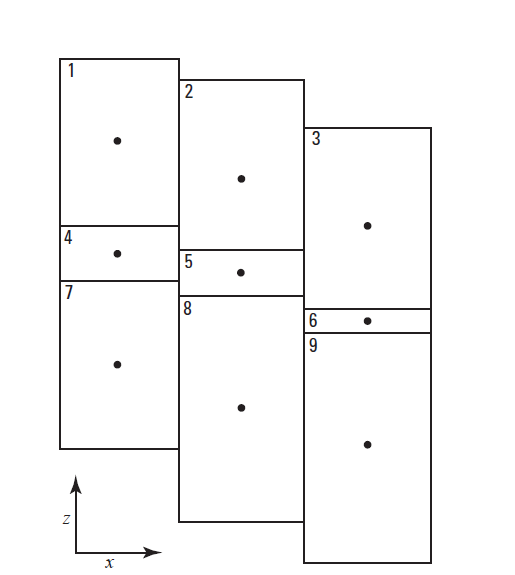

Dans cette image, dans un package DIS et DISV la cellule 6 est uniquement connecté (horizontalement) à la cellule 5 alors qu'il parait plus évident qu'elle soit par 8. Il est possible de régler cela dans le package DISU en fixant les connexions de la cellule 6, *et il me semble que Gridgen le fait tout seul mais il faudrait vérifier...*

### Bon assez rigolé, passons aux choses sérieuses et créeons un petit modèle avec ce qu'on a !

### Implémentation d'une charge constante avec la rivière
il va falloir extraire les cellules intersecté par le shp ainsi que leur longueur pour pouvoir réaliser une interpolation linéaire des charges le long de la rivière

In [21]:
intersect = g.intersect(Riv_path,"line",0) # pas plus compliqué que cela
nod = intersect.nodenumber # BOOM, attention parfois gridgen retourne plusieurs fois la même cellule /o\

# prenons aussi les longueurs
l = intersect.length

# créons un package pour la rivière (comme on va utiliser un disv le cellid se présente comme ceci : (layer,nodenumber))
riv_spd = []

# extract cumulative length in order to interpolate river stage
l_cum = []
l_cumul = 0
for leng in l:
    l_cumul += leng/2
    l_cum.append(l_cumul)
    l_cumul += leng/2

# define up and downstream stage and interpolate
us = 180 # upstream stage
ds = 0 # downstream stage
stage = np.interp(l_cum,[0,l_cum[-1]],[us,ds])

#create spd package
for i, inode in enumerate(nod):
    i = int(i)
    if inode!= -2:  # When nodenumber == -2, it means the point (or line) is outside of the grid and thus must not be added to the model
        cellid = (0,inode) # layer, nodenumber
        st = stage[i] # stage of the river
        riv_bot = st - 1 # botom of the river (1 m depth)
        cond = 0.01 # conductance

        riv_spd.append((cellid,st,cond,riv_bot))

In [22]:
riv_spd[:4]

[((0, 1244), 178.22687548394546, 0.01, 177.22687548394546),
 ((0, 1247), 177.61581608478298, 0.01, 176.61581608478298),
 ((0, 1254), 177.23786671205073, 0.01, 176.23786671205073),
 ((0, 1250), 176.58108214439252, 0.01, 175.58108214439252)]

### Implémentons des puits

In [23]:
puit_int = g.intersect(coor_wel,"point",0) 

wel_spd=[] # list with data about wells
q = -5e-2 # uptake from wells in m3/s, note "-" sign

for nod in puit_int.nodenumber:
    if nod != -2: # When nodenumber == -2, it means the point is outside of the grid and thus must not be added to the model
        cellid = (0,nod)
        wel_spd.append((cellid,q))

### Créons les différents packages (vous devez avoir l'habitude maintenant...)

In [24]:
# VERY basic modules
sim = fp.mf6.MFSimulation(sim_name='DISV', version='mf6', exe_name=exe_name, 
                         sim_ws=model_dir)
gwf = fp.mf6.ModflowGwf(sim, modelname=model_name,
                           model_nam_file='{}.nam'.format(model_name))
disv = fp.mf6.ModflowGwfdisv(gwf, nlay=nlay, ncpl=ncpl,nvert=nvert,vertices=vert,cell2d=cell2d,
                              top=100, botm=-50,idomain=1)

#discrétisation temporelle
tdis = fp.mf6.ModflowTdis(sim, time_units='SECONDS',perioddata=[[1.0, 1, 1.]])

#solver
ims  = fp.mf6.ModflowIms(sim, print_option='SUMMARY', complexity="simple")

# initial conditions
ic   = fp.mf6.ModflowGwfic(gwf,strt=-49)

# output control (fichiers de sortie)
oc   = fp.mf6.ModflowGwfoc(gwf,budget_filerecord='{}.cbc'.format(model_name),#nom du fichier budget (ne pas changer)
                            head_filerecord='{}.hds'.format(model_name),# nom du fichier des charges (ne pas changer)
                            saverecord=[('HEAD', 'LAST'), 
                                        ('BUDGET', 'LAST')],
                            printrecord=[('BUDGET', 'ALL')])

# nodeflowproperty (conductivité, flux à enregistrer, ...)
k = 1e-4
npf  = fp.mf6.ModflowGwfnpf(gwf, icelltype=0, k=k,save_flows=True,save_specific_discharge=True)

# un peu de recharge malgré tout
rcha = 100 # mm/yr
rch = fp.mf6.ModflowGwfrcha(gwf,recharge=rcha/1000/86400/365,save_flows=True)

#initialise les puits
wel = fp.mf6.ModflowGwfwel(gwf,pname="wel",maxbound=len(wel_spd),
                           stress_period_data=wel_spd,save_flows=True)




# riv
riv = fp.mf6.ModflowGwfriv(gwf,pname="Tet",maxbound=len(riv_spd),stress_period_data=riv_spd,save_flows=True)

In [25]:
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model Modele_raffine...
    writing model name file...
    writing package disv...
    writing package ic...
    writing package oc...
    writing package npf...
    writing package rcha...
    writing package wel...
    writing package tet...
FloPy is using the following  executable to run the model: ../../../../../exe/mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.0.4 03/13/2019

   MODFLOW 6 compiled Mar 21 2019 15:37:31 with IFORT compiler (ver. 19.0.0)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by

(True, [])

In [26]:
head = get_heads(model_name,model_dir)
spdis = get_spdis(model_name,model_dir)

Text(665000.0, 6190000.0, "Cool ! :D \n\nExcept for the contours :(\nbut hey ! It's free...")

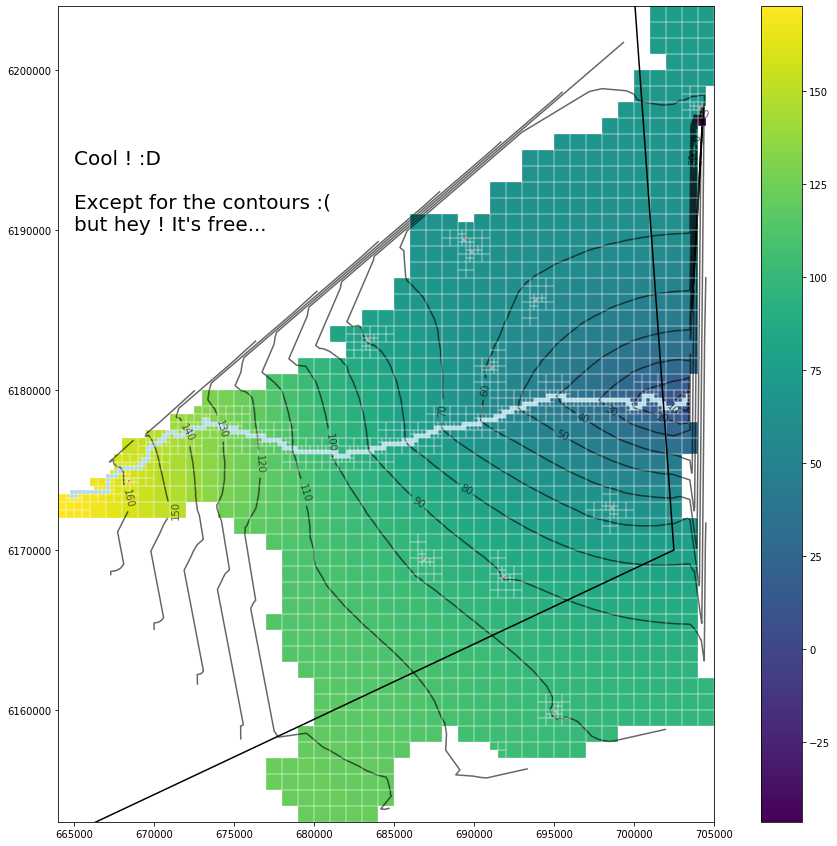

In [27]:
#récupération des données
fig = plt.figure(figsize=(17,15))
layer = 0
ax  = plt.subplot(1, 1,1, aspect='equal')
ml = fp.plot.PlotMapView(model=gwf,layer=layer)
hmesh=ml.plot_array(head[layer],masked_values=[0,1e30],cmap="viridis")
cont = ml.contour_array(head[layer],colors="black",levels=np.arange(0,170,10),alpha=0.6)
plt.clabel(cont,fmt="%1i")

#bc
ml.plot_bc("Tet",color="lightblue")
ml.plot_bc("wel")

#section

line = np.array([(x0,y0),(x0+4.25e4,y0+2e4),(x0+4e4,y1)])
plt.plot(line.T[0],line.T[1],"k")

plt.colorbar(hmesh)
ml.plot_grid(alpha=0.2,color="white")
plt.text(x0+0.5e4,y0+4e4,"Cool ! :D \n\nExcept for the contours :(\nbut hey ! It's free...",fontsize=20)

### faire une coupe en non structuré ! pas simple

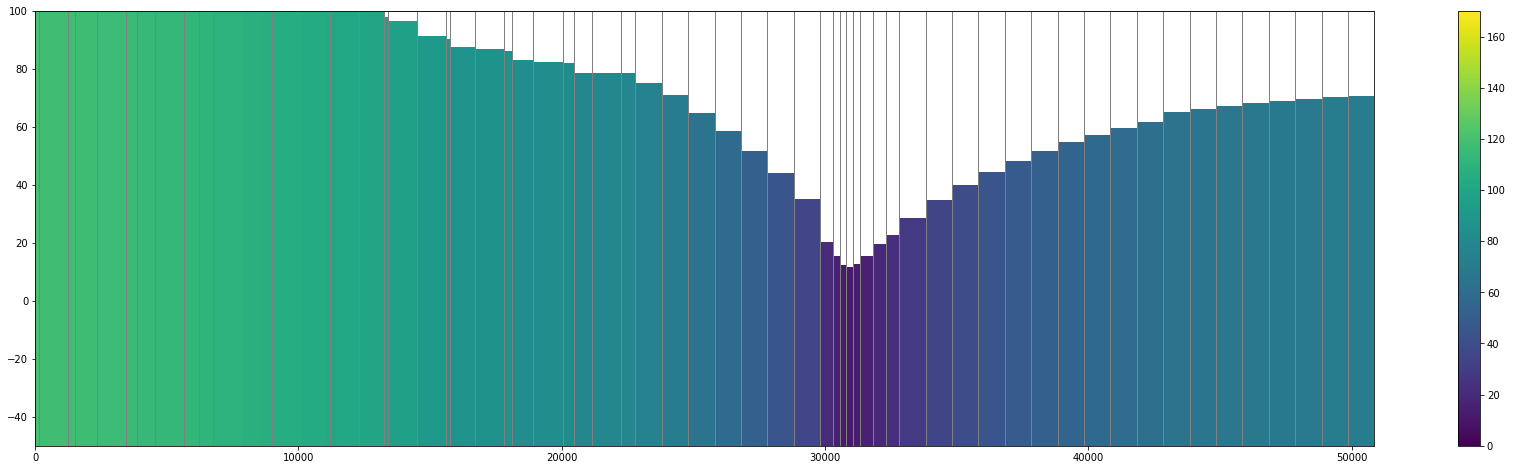

In [28]:
# l'affichage des conditions limites ne marche pas !
fig,ax = plt.subplots(figsize=(30,8))
x=fp.plot.PlotCrossSection(gwf,line={"line":line})

arr=x.plot_array(head,masked_values=[1e30],head=head)
plt.colorbar(arr)
x.plot_grid() # afficher le maillage
arr.set_clim(0,170)
